In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

In [15]:
cases_malaysia = pd.read_csv('cases_malaysia.csv')
cases_state = pd.read_csv('cases_state.csv')
clusters = pd.read_csv('clusters.csv')
tests_malaysia = pd.read_csv('tests_malaysia.csv')
tests_state = pd.read_csv('tests_state.csv')

cases_malaysia['date'] = pd.to_datetime(cases_malaysia['date'],errors = 'coerce')
cases_state['date'] = pd.to_datetime(cases_state['date'],errors = 'coerce')
clusters['date_announced'] = pd.to_datetime(clusters['date_announced'],errors = 'coerce')
tests_malaysia['date'] = pd.to_datetime(tests_malaysia['date'],errors = 'coerce')
tests_state['date'] = pd.to_datetime(tests_state['date'],errors = 'coerce')

<h1>DataSets</h1>

<h3>Cases Malaysia</h3>

25/1/2020 - 6/9/2021 <br>
Cluster data starts 1/1/2021

<h3>Clusters</h3>

<h1>Exploratory Data Analysis</h1>

<h3>Cases Malaysia</h3>

Index(['date', 'cases_new', 'cases_import', 'cases_recovered',
       'cluster_import', 'cluster_religious', 'cluster_community',
       'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre',
       'cluster_workplace'],
      dtype='object')


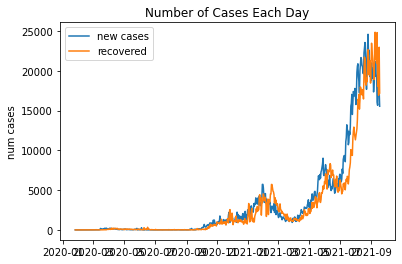

In [16]:
print(cases_malaysia.columns)

# Cases each day
plt.plot(cases_malaysia['date'],cases_malaysia['cases_new'],label = "new cases")
plt.plot(cases_malaysia['date'], cases_malaysia['cases_recovered'], label = "recovered")
plt.title("Number of Cases Each Day")
plt.ylabel("num cases")
plt.legend()
plt.show()


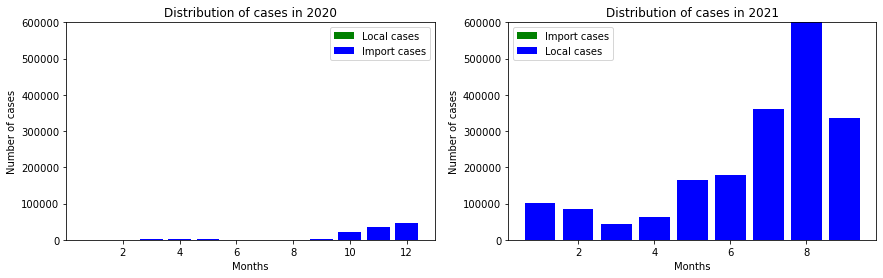

In [17]:
# Distribution of cases each month
cases_2020 = cases_malaysia[cases_malaysia['date'].dt.year == 2020]
cases_2020 = cases_2020.groupby(cases_2020['date'].dt.month).sum()
cases_2020 = cases_2020.reset_index()

cases_2021 = cases_malaysia[cases_malaysia['date'].dt.year == 2021]
cases_2021 = cases_2021.groupby(cases_2021['date'].dt.month).sum()
cases_2021 = cases_2021.reset_index()

plt.subplot(1,2,1)
plt.bar(cases_2020['date'],cases_2020['cases_import'],color = 'g')
plt.bar(cases_2020['date'],cases_2020['cases_new'] - cases_2020['cases_import'], color = 'b', bottom = cases_2020['cases_import'])
plt.ylim(0,600000)
plt.xlabel("Months")
plt.ylabel("Number of cases")
plt.title("Distribution of cases in 2020")
plt.legend(["Local cases","Import cases"])

plt.subplot(1,2,2)
plt.bar(cases_2021['date'],cases_2021['cases_import'],color = 'g')
plt.bar(cases_2021['date'],cases_2021['cases_new'] - cases_2021['cases_import'], color = 'b', bottom = cases_2021['cases_import'])
plt.ylim(0,600000)
plt.xlabel("Months")
plt.ylabel("Number of cases")
plt.title("Distribution of cases in 2021")
plt.legend(["Import cases","Local cases"])

plt.subplots_adjust(right = 2)
plt.show()


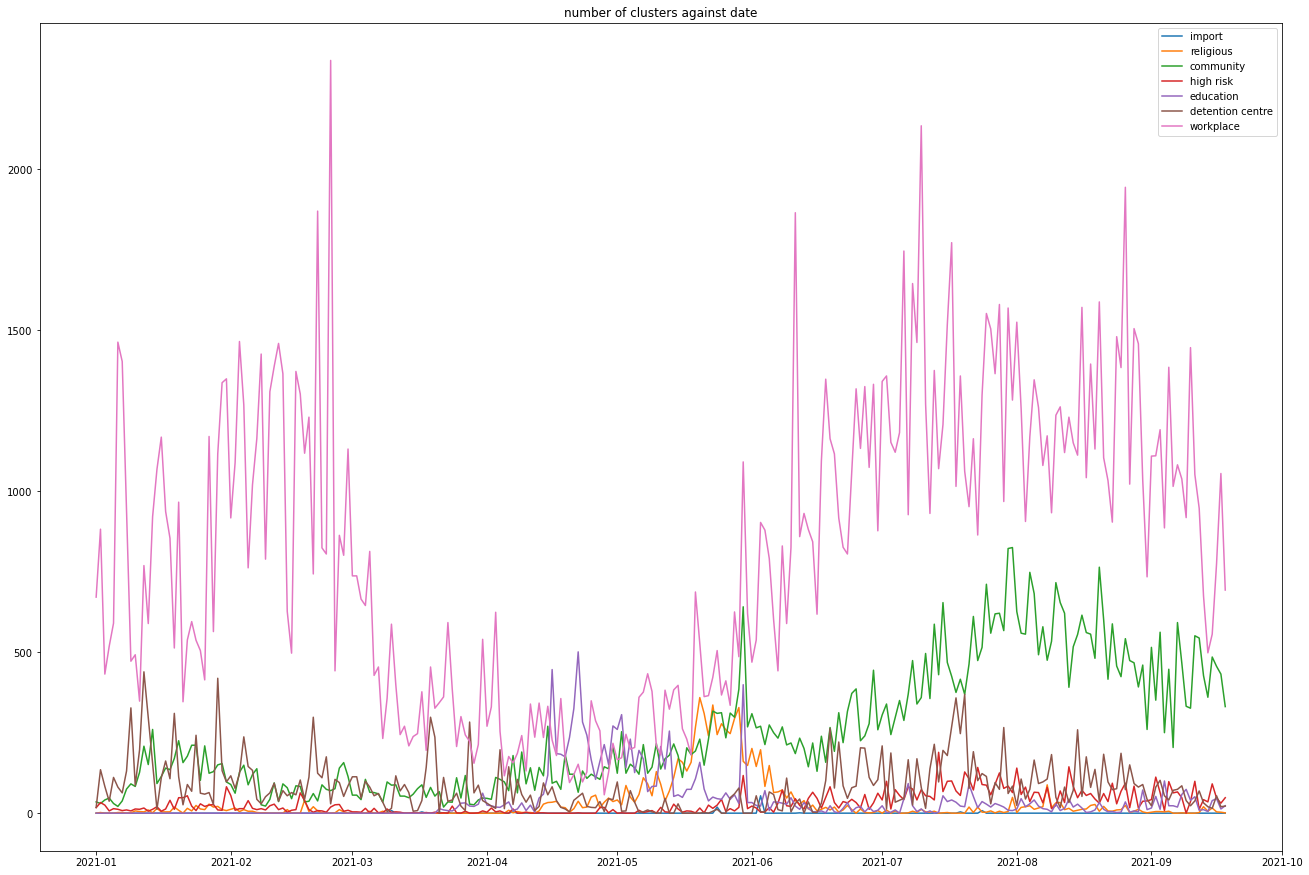

In [18]:
plt.plot(cases_malaysia['date'],cases_malaysia['cluster_import'],label = 'import')
plt.plot(cases_malaysia['date'],cases_malaysia['cluster_religious'],label = 'religious')
plt.plot(cases_malaysia['date'],cases_malaysia['cluster_community'],label = 'community')
plt.plot(cases_malaysia['date'],cases_malaysia['cluster_highRisk'],label = 'high risk')
plt.plot(cases_malaysia['date'],cases_malaysia['cluster_education'],label = 'education')
plt.plot(cases_malaysia['date'],cases_malaysia['cluster_detentionCentre'],label = 'detention centre')
plt.plot(cases_malaysia['date'],cases_malaysia['cluster_workplace'],label = 'workplace')

plt.subplots_adjust(right=3,top=3)
plt.title("number of clusters against date")
plt.legend()


<h2>Cases State</h2>

Index(['date', 'state', 'cases_import', 'cases_new', 'cases_recovered'], dtype='object')


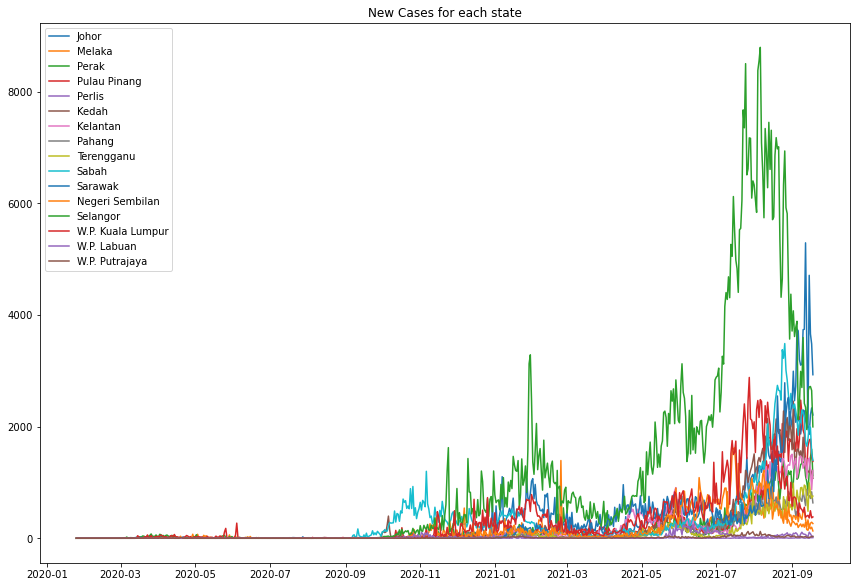

In [19]:
# Cases State

print(cases_state.columns)
states = ['Johor','Melaka','Perak','Pulau Pinang', 'Perlis', 'Kedah', 'Kelantan', 'Pahang', 'Terengganu', 'Sabah', 'Sarawak', 'Negeri Sembilan', 'Selangor', 'W.P. Kuala Lumpur', 'W.P. Labuan', 'W.P. Putrajaya']

for i in states:
    plt.plot(cases_state[cases_state['state'] == i]['date'], cases_state[cases_state['state'] == i]['cases_new'], label = i)
    
plt.title('New Cases for each state')
plt.legend()
plt.subplots_adjust(top = 2, right = 2)


<h1>Malaysia Dataset </h1>

In [20]:
# get the y value for the model (number of tommorows cases)
cases = []
for j in cases_malaysia.index:
    cases.append(cases_malaysia['cases_new'][j])

cases.pop(0)
cases.append(0)

cases_malaysia['predict_cases'] = cases

# Calculate active cases
cumulative = 0
activecase = []
for i in cases_malaysia.index:
    cumulative = cumulative + cases_malaysia['cases_new'][i] - cases_malaysia['cases_recovered'][i]
    activecase.append(cumulative)
    
cases_malaysia['active_cases'] = activecase


# Merging malaysia df and calculate the positivity rate and active cases
malaysia = cases_malaysia.merge(tests_malaysia, on ='date')

# Calculate daily positivity rate
malaysia['daily_positivity_rate'] = round(malaysia['cases_new'] / (malaysia['rtk-ag'] + malaysia['pcr']) * 100,2)

malaysia = malaysia.drop(['cluster_import','cluster_religious','cluster_community','cluster_highRisk','cluster_education','cluster_detentionCentre','cluster_workplace'],axis = 1)

malaysia = malaysia

malaysia

,date,cases_new,cases_import,cases_recovered,predict_cases,active_cases,rtk-ag,pcr,daily_positivity_rate
0,2020-01-25,4,4,0,0,4,0,5,80.00
1,2020-01-26,0,0,0,0,4,0,14,0.00
2,2020-01-27,0,0,0,0,4,0,24,0.00
3,2020-01-28,0,0,0,3,4,0,53,0.00
4,2020-01-29,3,3,0,1,7,0,71,4.23
...,...,...,...,...,...,...,...,...,...
597,2021-09-13,16073,21,24813,15669,249248,84811,50451,11.88
598,2021-09-14,15669,17,18053,19495,246864,83980,66191,10.43
599,2021-09-15,19495,11,18760,18815,247599,79454,62947,13.69
600,2021-09-16,18815,7,16939,17577,249475,47522,48838,19.53


<h1>Formatting the state DF</h1>

In [21]:
# Formatting the State column

nameList = ['Johor','Kedah','Kelantan','Melaka','Negeri Sembilan','Pahang','Perak','Perlis','Pulau Pinang','Sabah','Sarawak','Selangor','Terengganu','W.P. Kuala Lumpur','W.P. Labuan','W.P. Putrajaya']

finalState = pd.DataFrame()

for i in nameList:
   
    tempDf = cases_state[cases_state['state'] == i]

    cumulative = 0
    activeList = []

    for h in tempDf.index:
        cumulative = cumulative + tempDf['cases_new'][h] - tempDf['cases_recovered'][h]
        activeList.append(cumulative)

    tempString = "active_case_" + i 
    tempDf[tempString] = activeList
    
    tempString2 = 'new_cases_' + i
    tempDf[tempString2] = tempDf['cases_new']
        
    tempDf = tempDf[['date',tempString2,tempString]]
    
    if (i == 'Johor'):
        finalState = tempDf
        
    else:
        finalState = finalState.merge(tempDf, on = 'date')
        
finalState
        

,date,new_cases_Johor,active_case_Johor,new_cases_Kedah,active_case_Kedah,new_cases_Kelantan,active_case_Kelantan,new_cases_Melaka,active_case_Melaka,new_cases_Negeri Sembilan,...,new_cases_Selangor,active_case_Selangor,new_cases_Terengganu,active_case_Terengganu,new_cases_W.P. Kuala Lumpur,active_case_W.P. Kuala Lumpur,new_cases_W.P. Labuan,active_case_W.P. Labuan,new_cases_W.P. Putrajaya,active_case_W.P. Putrajaya
0,2020-01-25,4,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-26,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-27,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-28,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-29,2,6,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,2021-09-14,1974,32053,1207,14351,1406,13910,329,6031,143,...,2632,47492,483,8362,411,9547,3,226,14,404
599,2021-09-15,1860,31970,1178,14118,1434,13891,190,5805,222,...,2710,46625,993,8970,363,9342,0,221,16,386
600,2021-09-16,2206,32092,1233,13730,1222,13814,269,5746,170,...,2718,45333,814,9499,493,9156,11,222,22,383
601,2021-09-17,2334,32157,1173,13253,869,13102,287,5538,198,...,2646,44436,719,8716,366,8818,10,228,31,377


<h1> Merging Final Dataframe and getting y columns for 4 states</h1>

In [22]:
# pahang johor kedah selangor

finalDf = malaysia.merge(finalState, on = 'date')

finalDf.to_csv("finalDf.csv")

In [23]:
q4 = ['Pahang','Johor','Kedah','Selangor']

df = pd.DataFrame()

for i in q4:
    tempDf = cases_state[cases_state['state'] == i]
    tempList = []
    
    for j in tempDf.index:
        tempList.append(tempDf['cases_new'][j])
    tempList.pop(0)
        
    tempString = i+'Y'
    
    if (i=='Pahang'):
        df = pd.DataFrame(tempList,columns = [tempString])
        
    else:
        df[tempString] = tempList
        
    tempList.clear()
        
display(df)

PahangY = df['PahangY']
JohorY = df['JohorY']
KedahY = df['KedahY']
SelangorY = df['SelangorY']


,PahangY,JohorY,KedahY,SelangorY
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,2,1,0
4,0,1,0,0
...,...,...,...,...
597,763,1974,1207,2632
598,766,1860,1178,2710
599,712,2206,1233,2718
600,832,2334,1173,2646


In [25]:
scaler = MinMaxScaler()

X = finalDf.drop(['date','predict_cases'], axis =1)
y = finalDf[['predict_cases']]

X = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(481, 39) (481, 1) (121, 39) (121, 1)


In [26]:
corelation = finalDf.corr()
corelation = corelation[['new_cases_Pahang','new_cases_Johor']]
corelation = corelation.loc[['new_cases_Perlis','new_cases_Kedah','new_cases_Pulau Pinang','new_cases_Kelantan','new_cases_Perak','new_cases_Negeri Sembilan','new_cases_Terengganu','new_cases_Melaka','new_cases_Johor','new_cases_Sabah','new_cases_Sarawak','new_cases_Selangor','new_cases_Pahang','new_cases_W.P. Kuala Lumpur','new_cases_W.P. Labuan','new_cases_W.P. Putrajaya']]
corelation

,new_cases_Pahang,new_cases_Johor
new_cases_Perlis,0.761457,0.822257
new_cases_Kedah,0.939837,0.898587
new_cases_Pulau Pinang,0.903361,0.929736
new_cases_Kelantan,0.899586,0.898667
new_cases_Perak,0.912959,0.927318
new_cases_Negeri Sembilan,0.627698,0.507957
new_cases_Terengganu,0.917024,0.917077
new_cases_Melaka,0.865629,0.776062
new_cases_Johor,0.900995,1.000000
new_cases_Sabah,0.845246,0.871907


<AxesSubplot:>

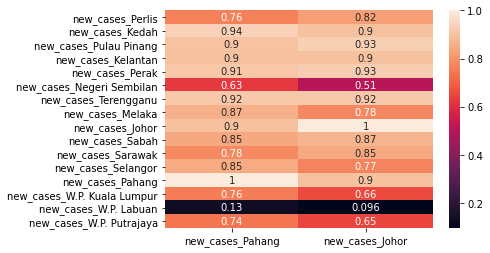

In [27]:
sns.heatmap(corelation, annot = True)

<h2>Feature Selection Malaysia</h2>

In [20]:
#Boruta 
rf = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', max_depth = 5)

boruta_selector = BorutaPy(rf, n_estimators = "auto", random_state = 1)

In [21]:
boruta_selector.fit(X,y)

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=176, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1C082206640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1C082206640)

In [22]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [23]:
# your codes here...
colnames = finalDf.drop(['date','predict_cases','state'], axis =1).columns

boruta_score = ranking(list(map(float,boruta_selector.ranking_)),colnames,order = -1)
boruta_score = pd.DataFrame(list(boruta_score.items()),columns = ['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending = False)

print('---------Top 10----------')
display(boruta_score.head(10))

print('---------Bottom 10----------')
boruta_score.tail(10)

---------Top 10----------


,Features,Score
15,new_cases_Negeri Sembilan,1.00
36,active_case_W.P. Labuan,0.97
29,new_cases_Selangor,0.95
35,new_cases_W.P. Labuan,0.92
5,pcr,0.89
13,new_cases_Melaka,0.87
8,active_case_Johor,0.87
10,active_case_Kedah,0.82
34,active_case_W.P. Kuala Lumpur,0.79
38,active_case_W.P. Putrajaya,0.76


---------Bottom 10----------


,Features,Score
18,active_case_Pahang,0.24
22,active_case_Perlis,0.18
28,active_case_Sarawak,0.18
30,active_case_Selangor,0.18
14,active_case_Melaka,0.13
31,new_cases_Terengganu,0.11
32,active_case_Terengganu,0.11
19,new_cases_Perak,0.05
11,new_cases_Kelantan,0.03
21,new_cases_Perlis,0.00


Text(0.5, 1.0, 'Boruta Top 30 Features')

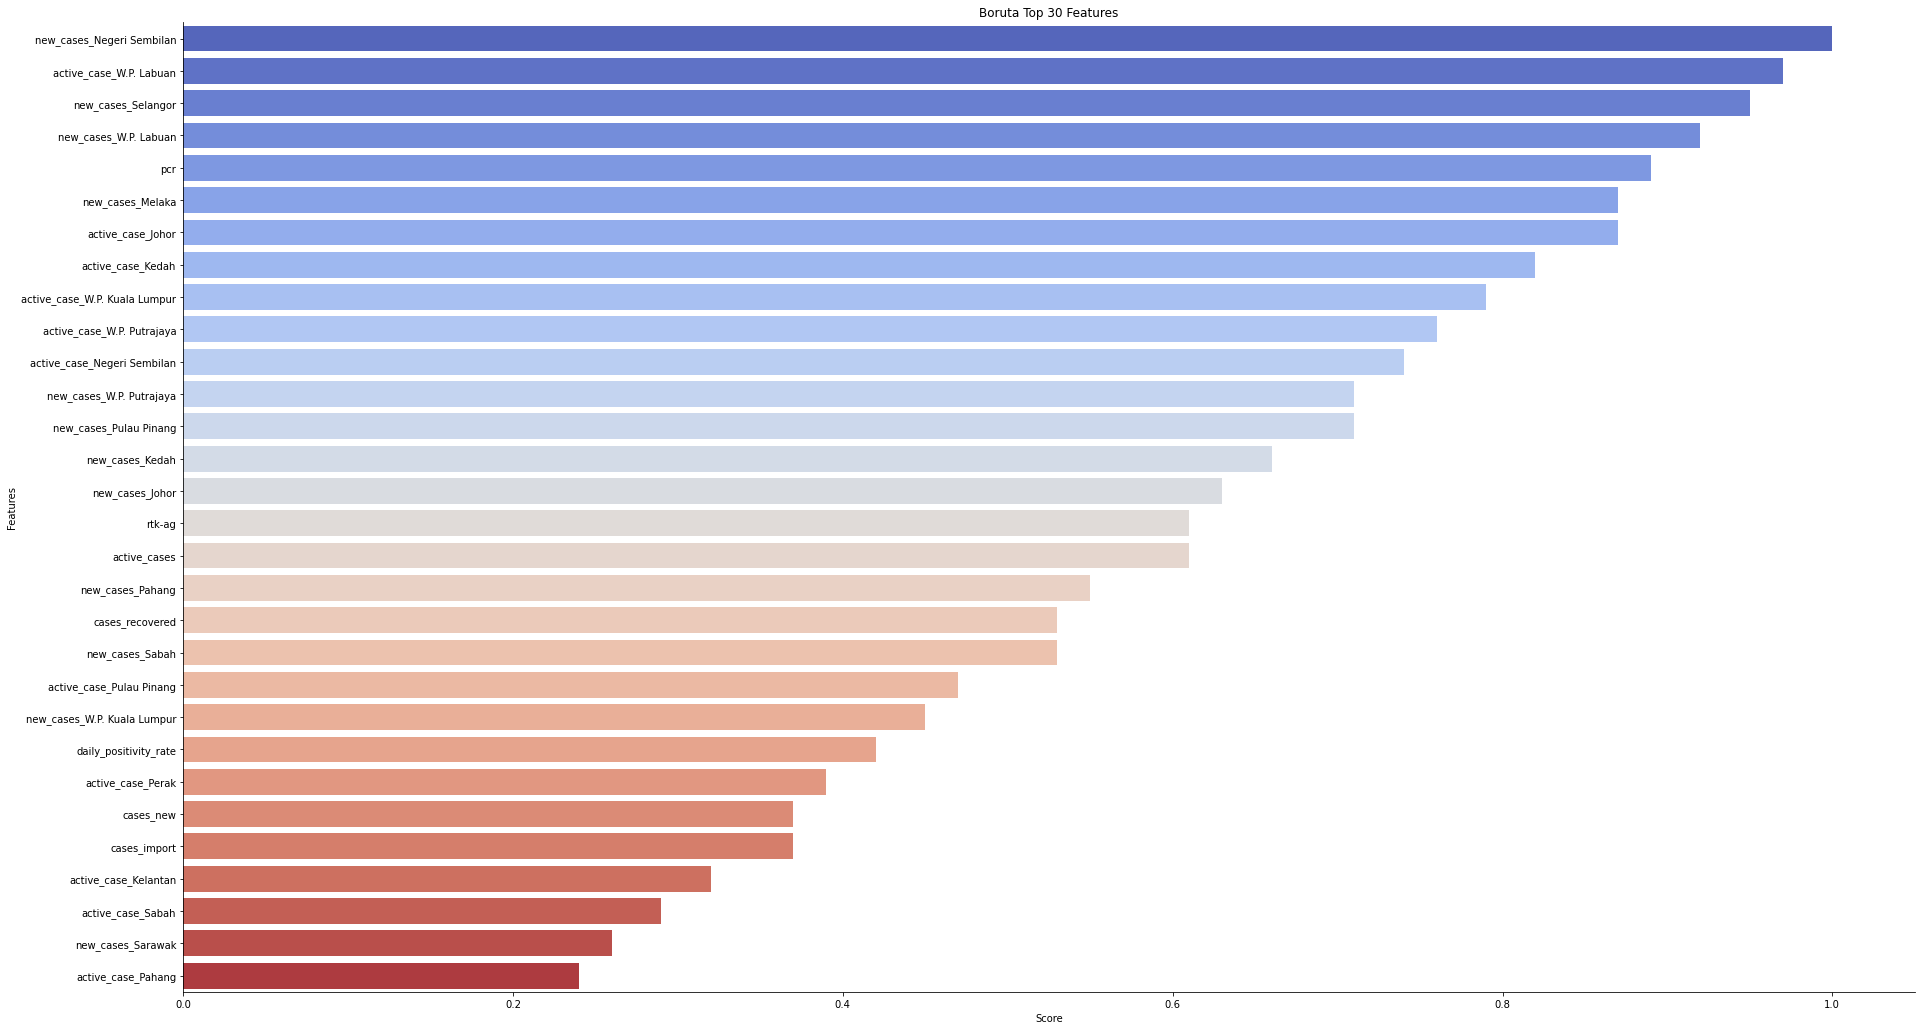

In [22]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta Top 30 Features")

In [33]:
# your codes here...
rf = RandomForestClassifier(n_jobs = -1, class_weight = "balanced", max_depth = 5, n_estimators = 100)
rf.fit(X,y)
rfe = RFECV(rf,min_features_to_select = 1, cv = 3)

In [24]:
rfe.fit(X,y)

RFECV(cv=3,
      estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                       n_jobs=-1))

In [25]:
rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

Text(0.5, 1.0, 'RFE Top 30 Features')

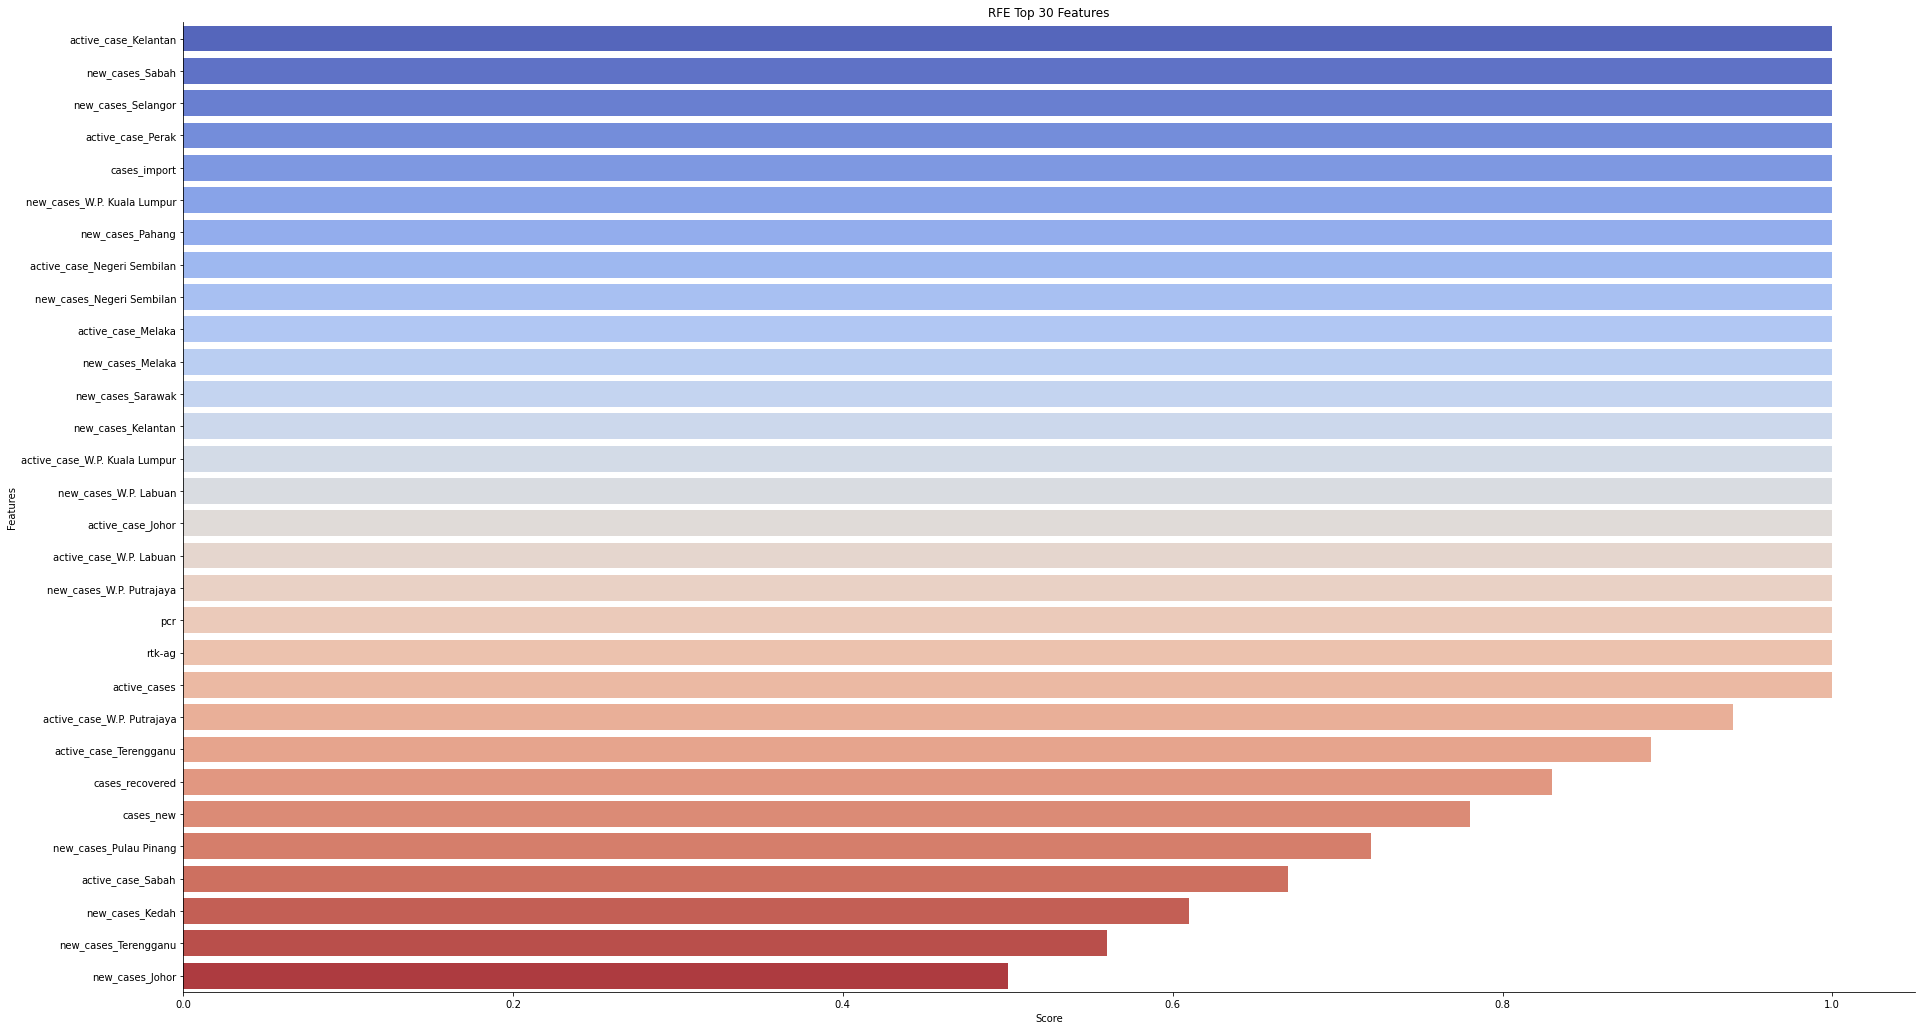

In [26]:
sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Top 30 Features")

<h2>Feature Selection Pahang</h2>

,Features,Score
4,rtk-ag,1.00
13,new_cases_Melaka,1.00
15,new_cases_Negeri Sembilan,1.00
14,active_case_Melaka,0.97
16,active_case_Negeri Sembilan,0.94
34,active_case_W.P. Kuala Lumpur,0.94
37,new_cases_W.P. Putrajaya,0.91
33,new_cases_W.P. Kuala Lumpur,0.89
1,cases_import,0.86
29,new_cases_Selangor,0.83


['rtk-ag' 'new_cases_Melaka' 'new_cases_Negeri Sembilan'
 'active_case_Melaka' 'active_case_Negeri Sembilan'
 'active_case_W.P. Kuala Lumpur' 'new_cases_W.P. Putrajaya'
 'new_cases_W.P. Kuala Lumpur' 'cases_import' 'new_cases_Selangor'
 'active_case_W.P. Putrajaya' 'pcr' 'active_cases' 'new_cases_W.P. Labuan'
 'active_case_Kedah' 'active_case_Selangor' 'new_cases_Terengganu'
 'active_case_Perak' 'active_case_Sabah' 'new_cases_Kedah'
 'active_case_Johor']


Text(0.5, 1.0, 'Boruta Top 30 Features')

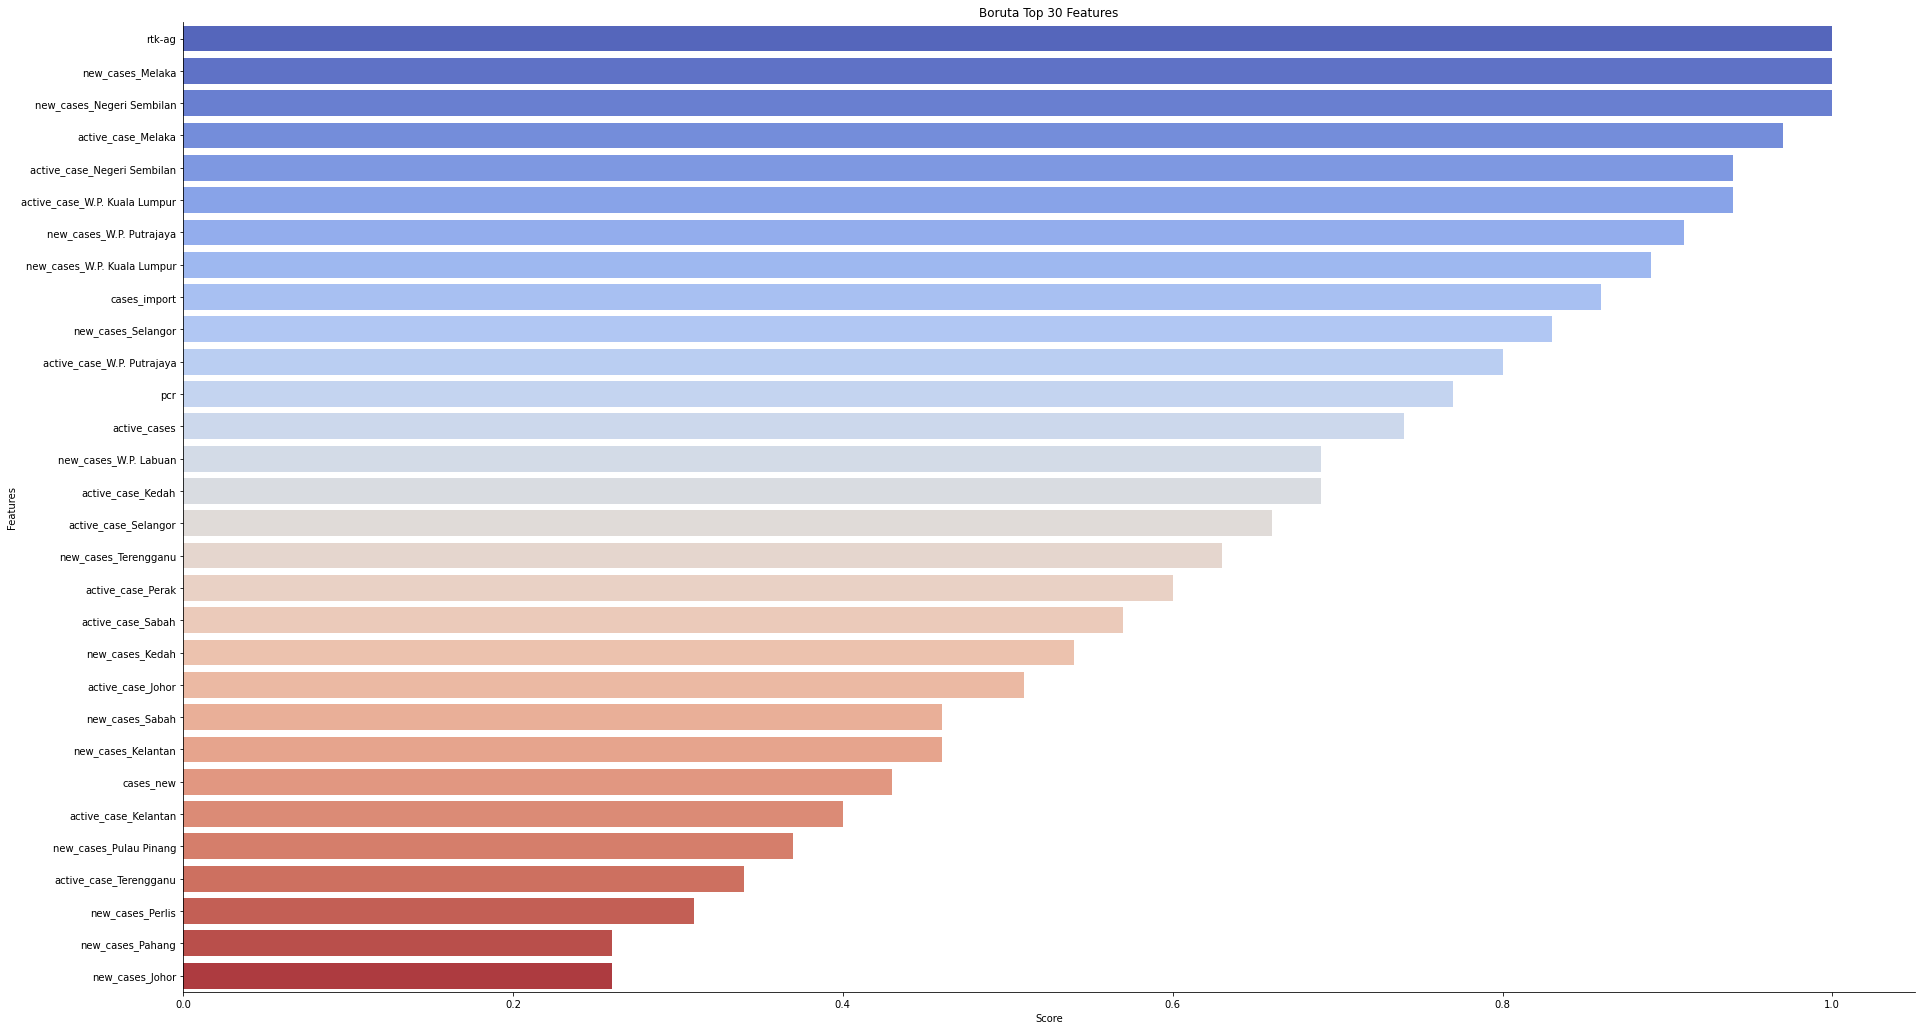

In [48]:
#Boruta 

boruta_selector.fit(X,PahangY)

# your codes here...
colnames = finalDf.drop(['date','predict_cases','state'], axis =1).columns

boruta_score = ranking(list(map(float,boruta_selector.ranking_)),colnames,order = -1)
boruta_score = pd.DataFrame(list(boruta_score.items()),columns = ['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending = False)

best_feature = boruta_score[boruta_score['Score'] >= 0.5]
display(best_feature)
print (best_feature['Features'].values)

boruta_score.reset_index()
#boruta_score.to_csv("Pahang_Boruta.csv")

sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta Top 30 Features")

,Features,Score
14,active_case_Melaka,1.00
33,new_cases_W.P. Kuala Lumpur,1.00
1,cases_import,1.00
17,new_cases_Pahang,1.00
16,active_case_Negeri Sembilan,1.00
15,new_cases_Negeri Sembilan,1.00
13,new_cases_Melaka,1.00
11,new_cases_Kelantan,1.00
10,active_case_Kedah,1.00
35,new_cases_W.P. Labuan,1.00


['active_case_Melaka' 'new_cases_W.P. Kuala Lumpur' 'cases_import'
 'new_cases_Pahang' 'active_case_Negeri Sembilan'
 'new_cases_Negeri Sembilan' 'new_cases_Melaka' 'new_cases_Kelantan'
 'active_case_Kedah' 'new_cases_W.P. Labuan' 'active_case_W.P. Labuan'
 'new_cases_W.P. Putrajaya' 'pcr' 'rtk-ag' 'active_cases'
 'new_cases_Selangor' 'active_case_W.P. Putrajaya' 'active_case_Selangor'
 'active_case_Sabah' 'cases_new']


Text(0.5, 1.0, 'RFE Top 30 Features')

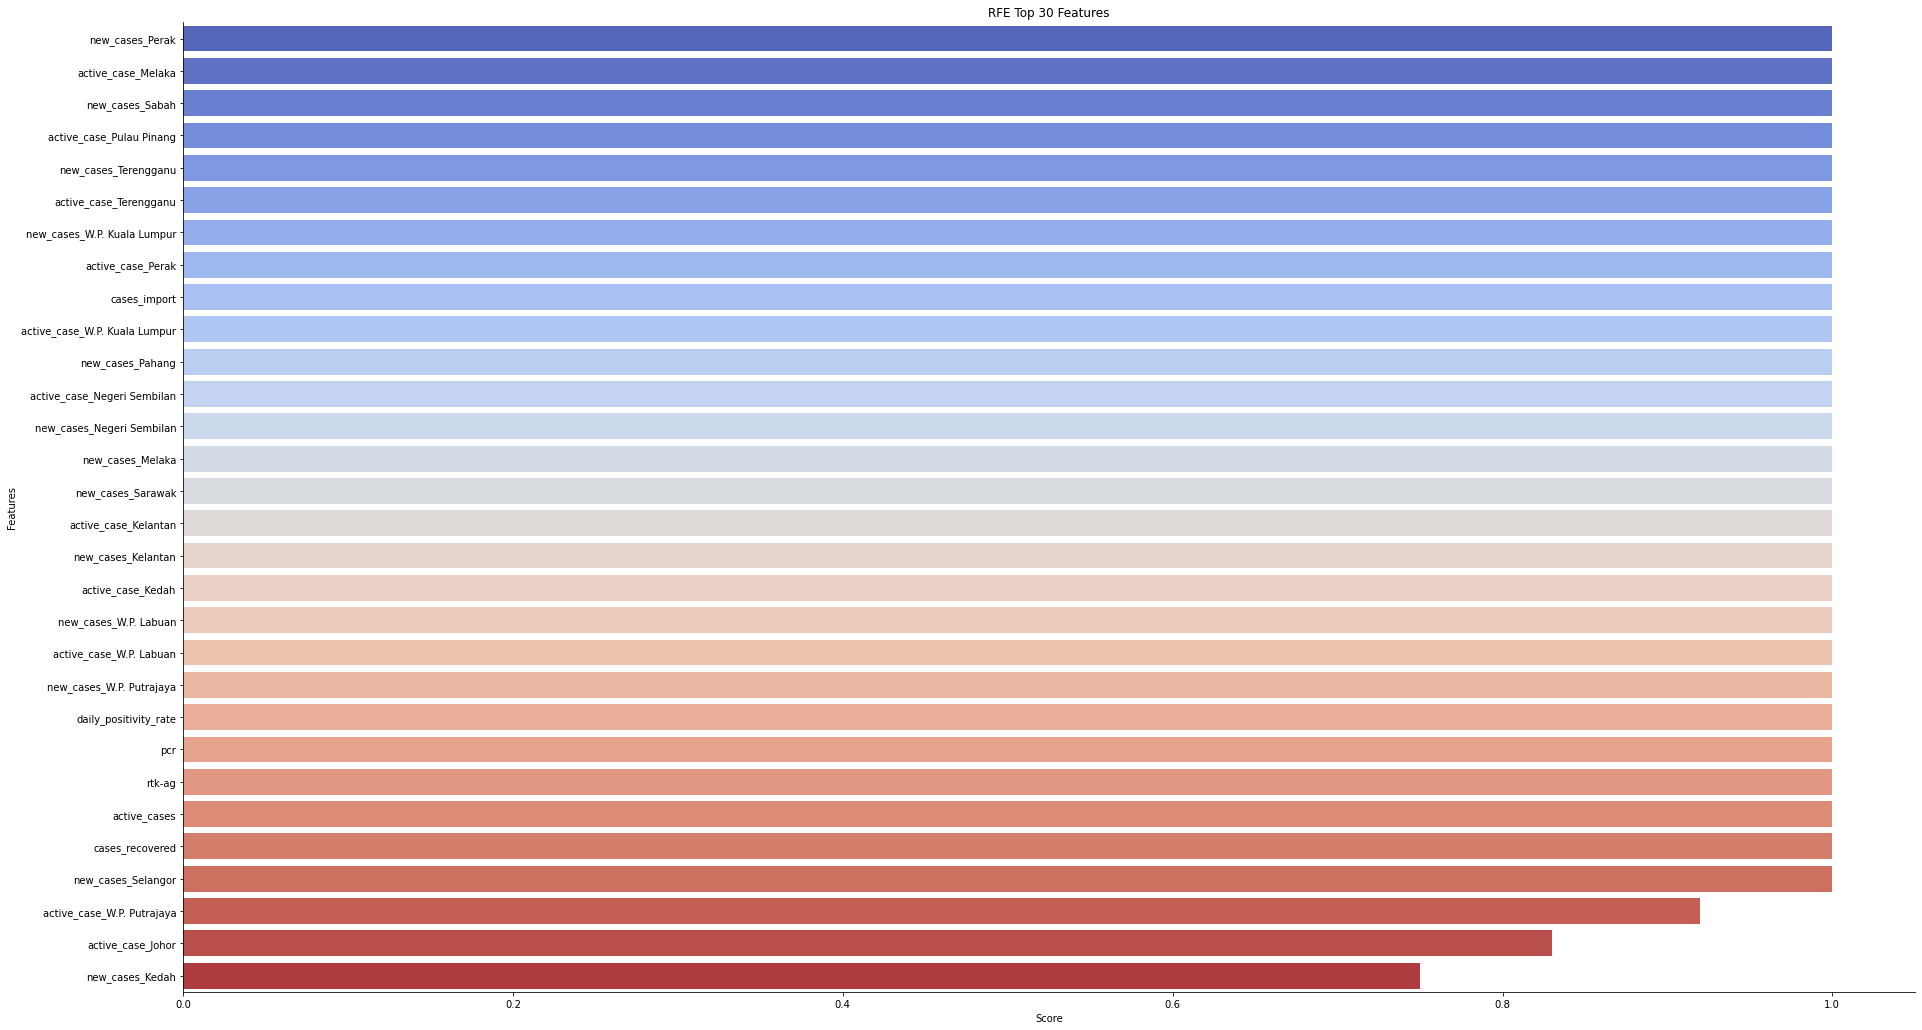

In [57]:
rfe.fit(X,PahangY)

rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

best_feature = rfe_score[boruta_score['Score'] >= 0.5]
display(best_feature)
print (best_feature['Features'].values)

#rfe_score.to_csv("rfe_Pahang.csv")

sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Top 30 Features")

<h2>Feature Selection Johor</h2>

,Features,Score
15,new_cases_Negeri Sembilan,1.00
16,active_case_Negeri Sembilan,0.97
4,rtk-ag,0.95
34,active_case_W.P. Kuala Lumpur,0.92
33,new_cases_W.P. Kuala Lumpur,0.89
2,cases_recovered,0.84
5,pcr,0.84
25,new_cases_Sabah,0.84
17,new_cases_Pahang,0.79
3,active_cases,0.74


['new_cases_Negeri Sembilan' 'active_case_Negeri Sembilan' 'rtk-ag'
 'active_case_W.P. Kuala Lumpur' 'new_cases_W.P. Kuala Lumpur'
 'cases_recovered' 'pcr' 'new_cases_Sabah' 'new_cases_Pahang'
 'active_cases' 'active_case_W.P. Labuan' 'active_case_Kedah'
 'active_case_Pahang' 'new_cases_Sarawak' 'active_case_Selangor'
 'active_case_Kelantan' 'active_case_Sabah' 'new_cases_Kedah'
 'new_cases_Melaka' 'new_cases_Pulau Pinang']


Text(0.5, 1.0, 'Boruta Top 30 Features')

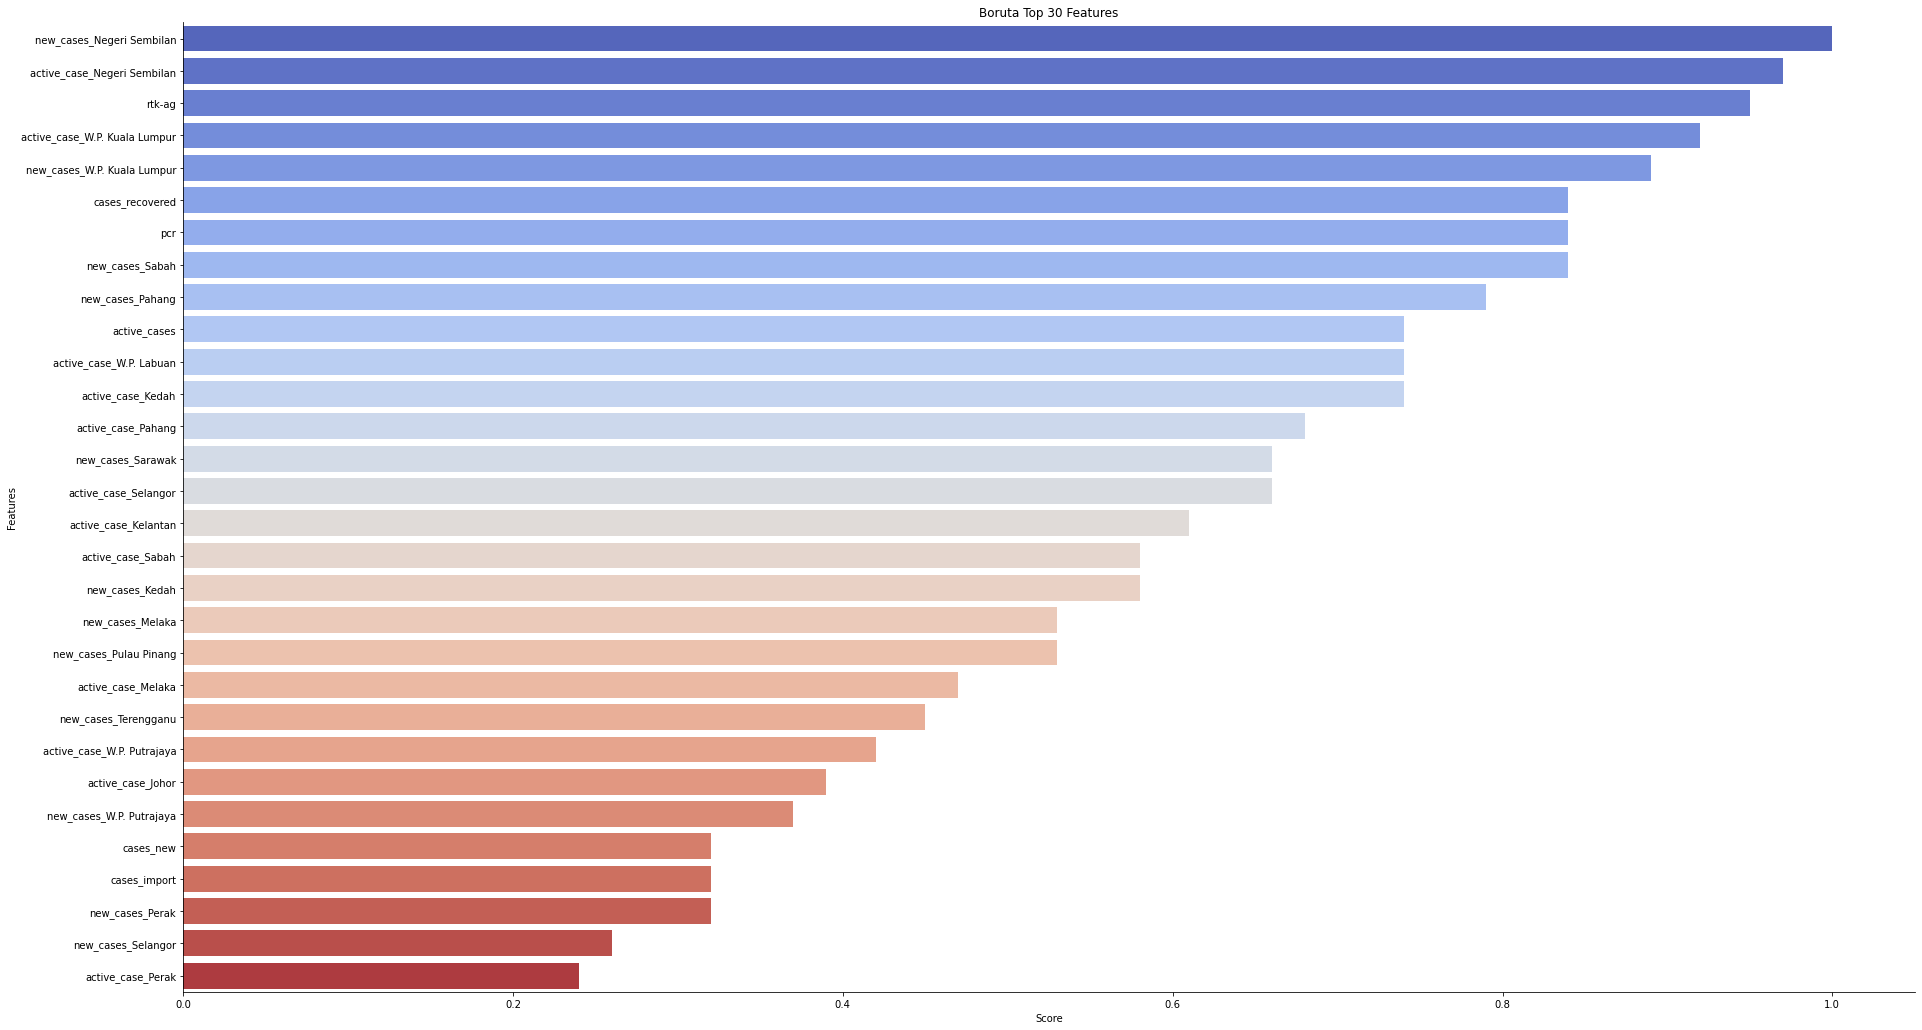

In [51]:
#Boruta 

boruta_selector.fit(X,JohorY)

# your codes here...
colnames = finalDf.drop(['date','predict_cases','state'], axis =1).columns

boruta_score = ranking(list(map(float,boruta_selector.ranking_)),colnames,order = -1)
boruta_score = pd.DataFrame(list(boruta_score.items()),columns = ['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending = False)

best_feature = boruta_score[boruta_score['Score'] >= 0.5]
display(best_feature)
print (best_feature['Features'].values)

#boruta_score.to_csv("Johor_Boruta.csv")

sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta Top 30 Features")

,Features,Score
36,active_case_W.P. Labuan,1.00
4,rtk-ag,1.00
5,pcr,1.00
15,new_cases_Negeri Sembilan,1.00
14,active_case_Melaka,1.00
33,new_cases_W.P. Kuala Lumpur,1.00
30,active_case_Selangor,1.00
11,new_cases_Kelantan,1.00
16,active_case_Negeri Sembilan,0.97
3,active_cases,0.83


['active_case_W.P. Labuan' 'rtk-ag' 'pcr' 'new_cases_Negeri Sembilan'
 'active_case_Melaka' 'new_cases_W.P. Kuala Lumpur' 'active_case_Selangor'
 'new_cases_Kelantan' 'active_case_Negeri Sembilan' 'active_cases'
 'new_cases_W.P. Labuan' 'new_cases_Selangor' 'new_cases_Melaka'
 'cases_import' 'active_case_W.P. Putrajaya' 'active_case_Kedah'
 'new_cases_W.P. Putrajaya' 'new_cases_Pahang' 'cases_new'
 'active_case_Sabah']


Text(0.5, 1.0, 'RFE Top 30 Features')

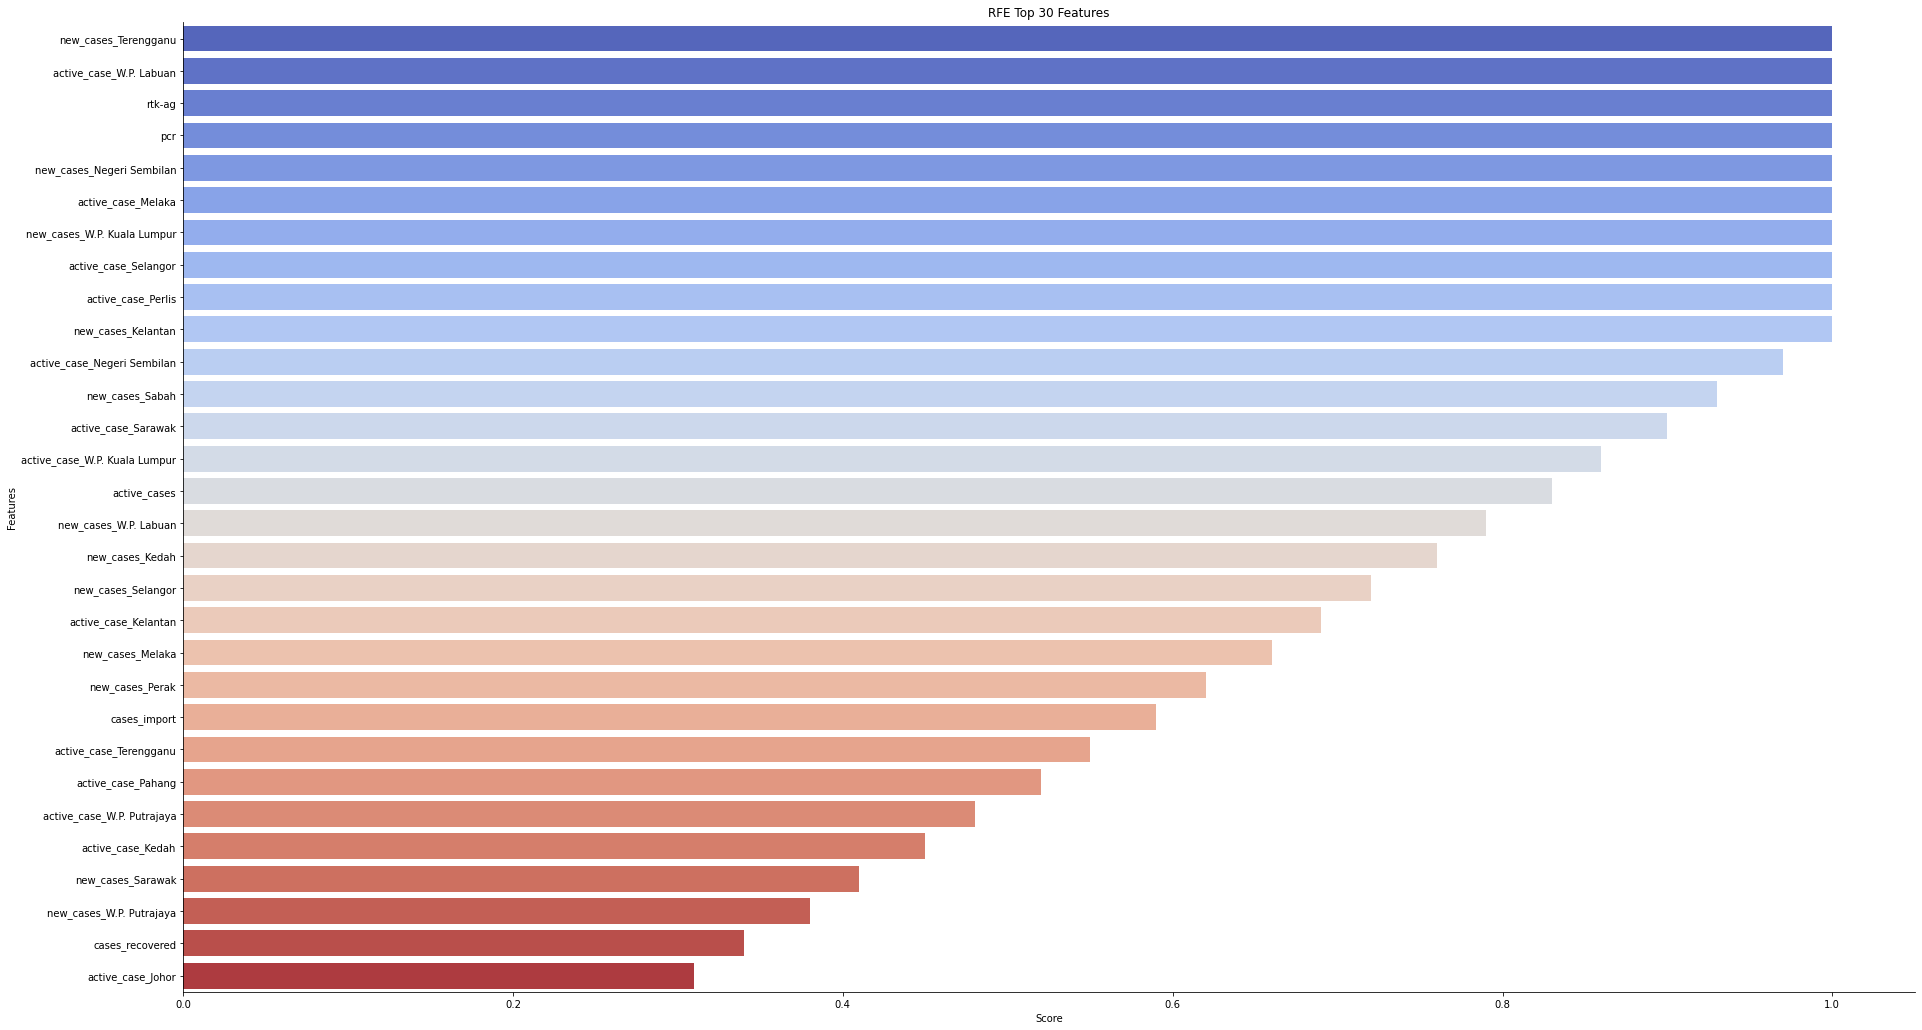

In [58]:
rfe.fit(X,JohorY)

rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

best_feature = rfe_score[boruta_score['Score'] >= 0.5]
display(best_feature)
print (best_feature['Features'].values)

#rfe_score.to_csv("rfe_Johor.csv")

sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Top 30 Features")

<h2>Feature Selection Kedah</h2>

,Features,Score
36,active_case_W.P. Labuan,1.00
2,cases_recovered,1.00
3,active_cases,1.00
34,active_case_W.P. Kuala Lumpur,1.00
12,active_case_Kelantan,1.00
14,active_case_Melaka,0.97
4,rtk-ag,0.97
13,new_cases_Melaka,0.97
18,active_case_Pahang,0.91
8,active_case_Johor,0.91


['active_case_W.P. Labuan' 'cases_recovered' 'active_cases'
 'active_case_W.P. Kuala Lumpur' 'active_case_Kelantan'
 'active_case_Melaka' 'rtk-ag' 'new_cases_Melaka' 'active_case_Pahang'
 'active_case_Johor' 'new_cases_Pahang' 'new_cases_W.P. Kuala Lumpur'
 'new_cases_Negeri Sembilan' 'new_cases_Kelantan' 'pcr'
 'new_cases_W.P. Putrajaya' 'active_case_Sabah' 'new_cases_Johor'
 'active_case_Negeri Sembilan' 'cases_new' 'active_case_Kedah'
 'new_cases_Selangor' 'new_cases_Terengganu']


Text(0.5, 1.0, 'Boruta Top 30 Features')

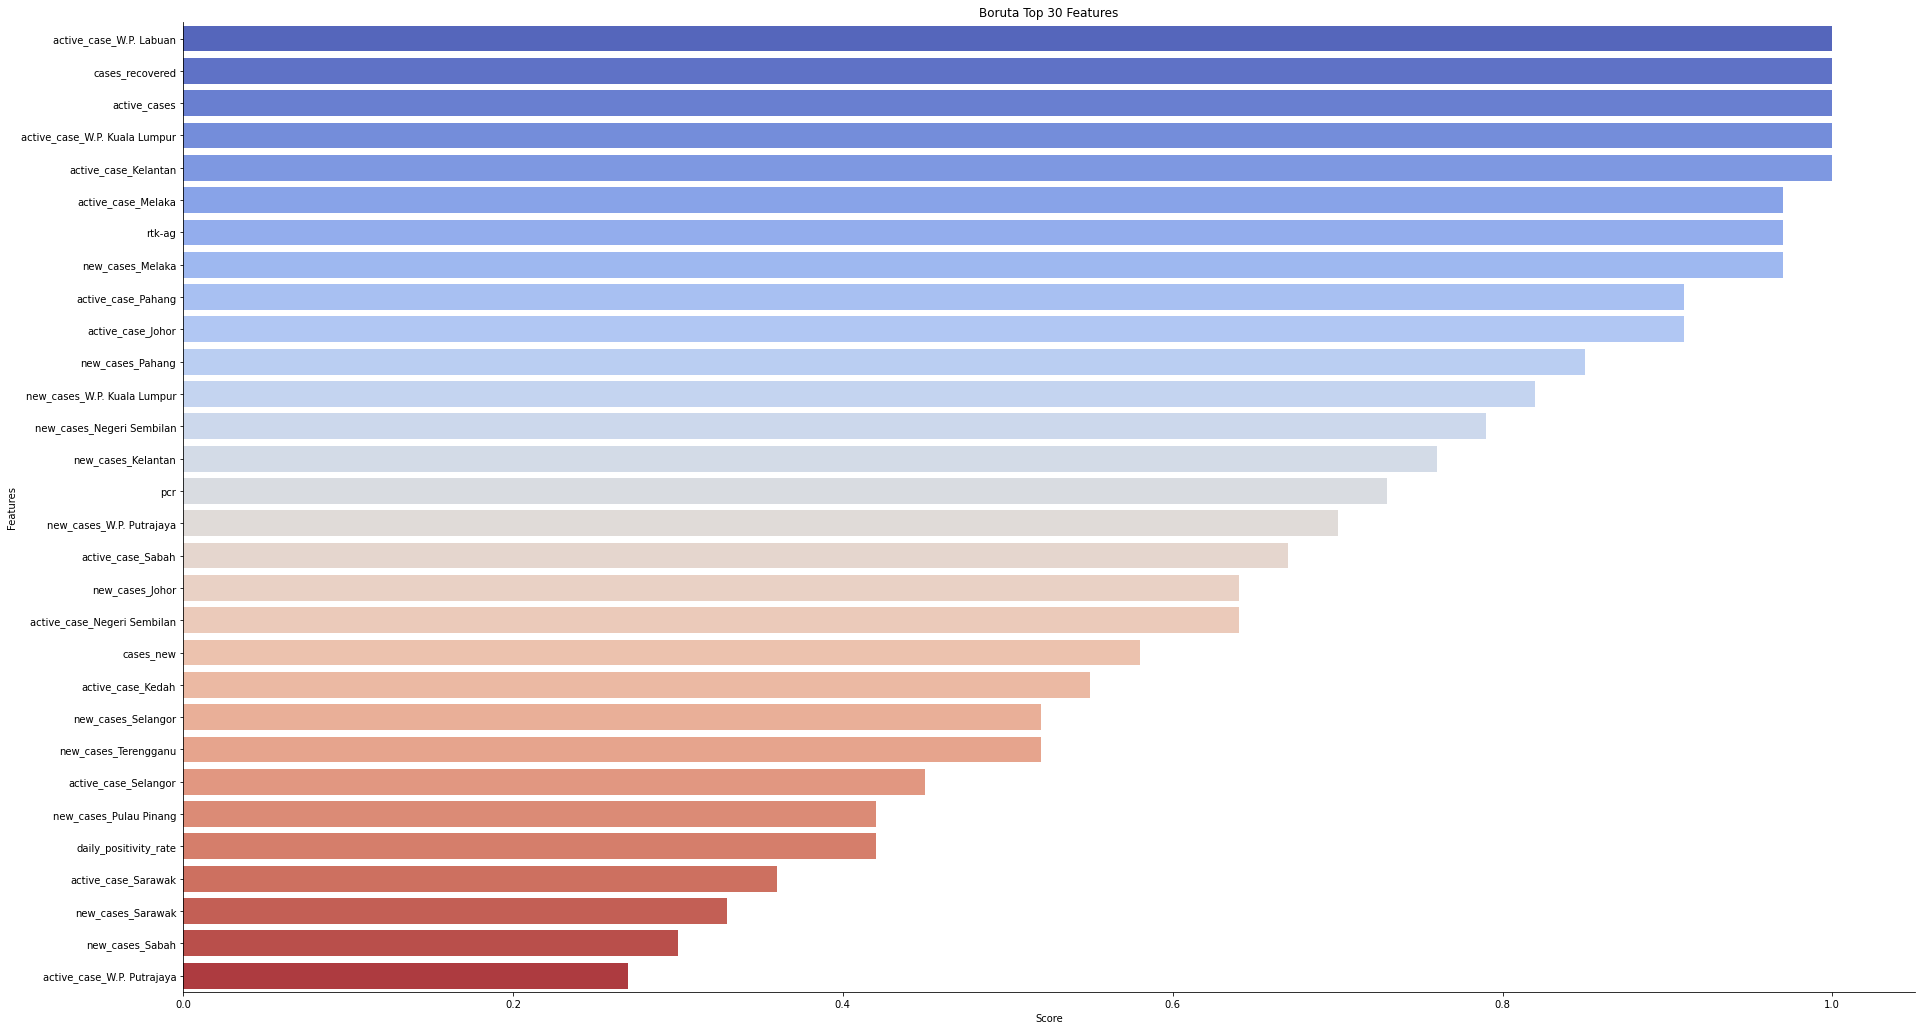

In [55]:
#Boruta 

boruta_selector.fit(X,KedahY)

# your codes here...
colnames = finalDf.drop(['date','predict_cases','state'], axis =1).columns

boruta_score = ranking(list(map(float,boruta_selector.ranking_)),colnames,order = -1)
boruta_score = pd.DataFrame(list(boruta_score.items()),columns = ['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending = False)

best_feature = boruta_score[boruta_score['Score'] >= 0.5]
display(best_feature)
print (best_feature['Features'].values)

#boruta_score.to_csv("Kedah_Boruta.csv")

sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta Top 30 Features")

,Features,Score
0,cases_new,1.00
26,active_case_Sabah,1.00
29,new_cases_Selangor,1.00
30,active_case_Selangor,1.00
33,new_cases_W.P. Kuala Lumpur,1.00
35,new_cases_W.P. Labuan,1.00
36,active_case_W.P. Labuan,1.00
37,new_cases_W.P. Putrajaya,1.00
10,active_case_Kedah,1.00
3,active_cases,1.00


['cases_new' 'active_case_Sabah' 'new_cases_Selangor'
 'active_case_Selangor' 'new_cases_W.P. Kuala Lumpur'
 'new_cases_W.P. Labuan' 'active_case_W.P. Labuan'
 'new_cases_W.P. Putrajaya' 'active_case_Kedah' 'active_cases' 'rtk-ag'
 'pcr' 'active_case_W.P. Putrajaya' 'new_cases_Kelantan'
 'new_cases_Melaka' 'active_case_Melaka' 'new_cases_Negeri Sembilan'
 'active_case_Negeri Sembilan' 'new_cases_Pahang' 'cases_import']


Text(0.5, 1.0, 'RFE Top 30 Features')

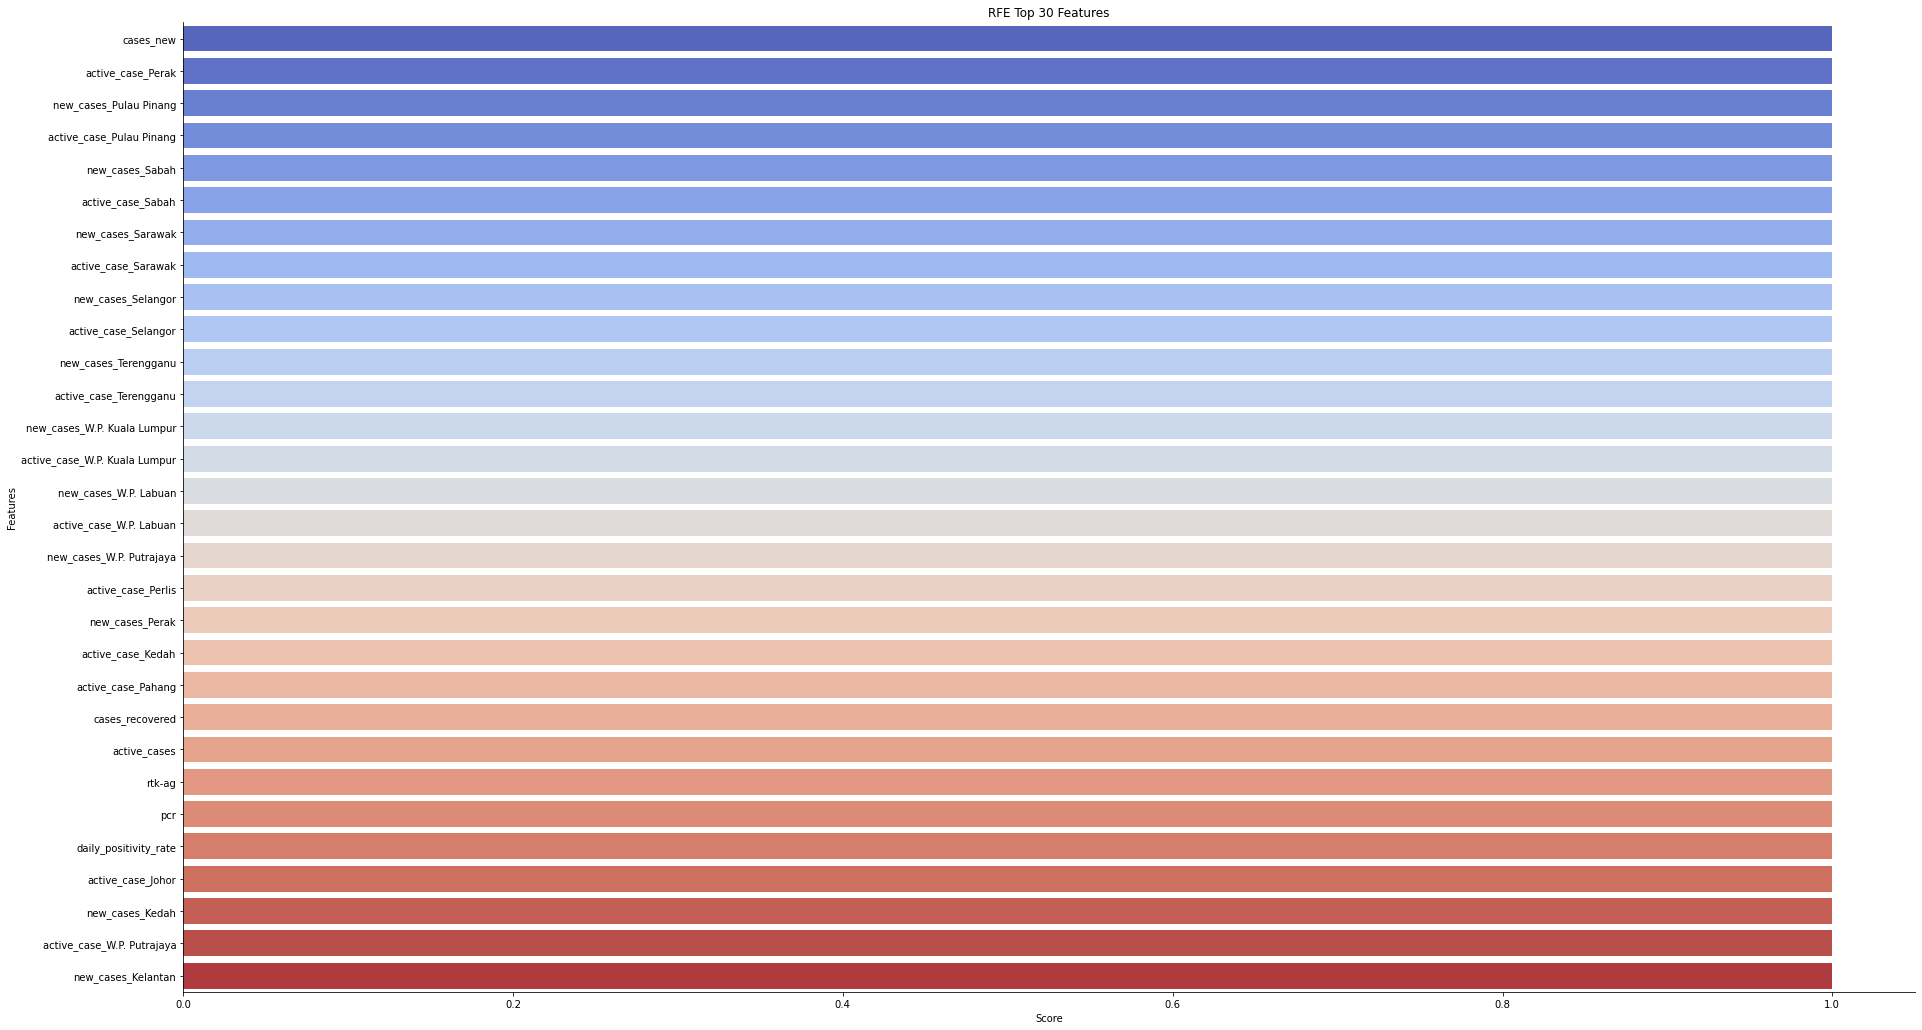

In [59]:
rfe.fit(X,KedahY)

rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

best_feature = rfe_score[boruta_score['Score'] >= 0.5]
display(best_feature)
print (best_feature['Features'].values)

#rfe_score.to_csv("rfe_Kedah.csv")

sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Top 30 Features")

<h2>Feature Selection Selangor</h2>

,Features,Score
15,new_cases_Negeri Sembilan,1.00
16,active_case_Negeri Sembilan,0.97
36,active_case_W.P. Labuan,0.95
35,new_cases_W.P. Labuan,0.95
4,rtk-ag,0.89
13,new_cases_Melaka,0.87
38,active_case_W.P. Putrajaya,0.84
29,new_cases_Selangor,0.84
37,new_cases_W.P. Putrajaya,0.79
3,active_cases,0.76


['new_cases_Negeri Sembilan' 'active_case_Negeri Sembilan'
 'active_case_W.P. Labuan' 'new_cases_W.P. Labuan' 'rtk-ag'
 'new_cases_Melaka' 'active_case_W.P. Putrajaya' 'new_cases_Selangor'
 'new_cases_W.P. Putrajaya' 'active_cases' 'active_case_Melaka'
 'cases_new' 'new_cases_Kelantan' 'active_case_Sabah' 'cases_import'
 'new_cases_W.P. Kuala Lumpur' 'new_cases_Pahang' 'pcr'
 'active_case_Selangor' 'active_case_Kedah']


Text(0.5, 1.0, 'Boruta Top 30 Features')

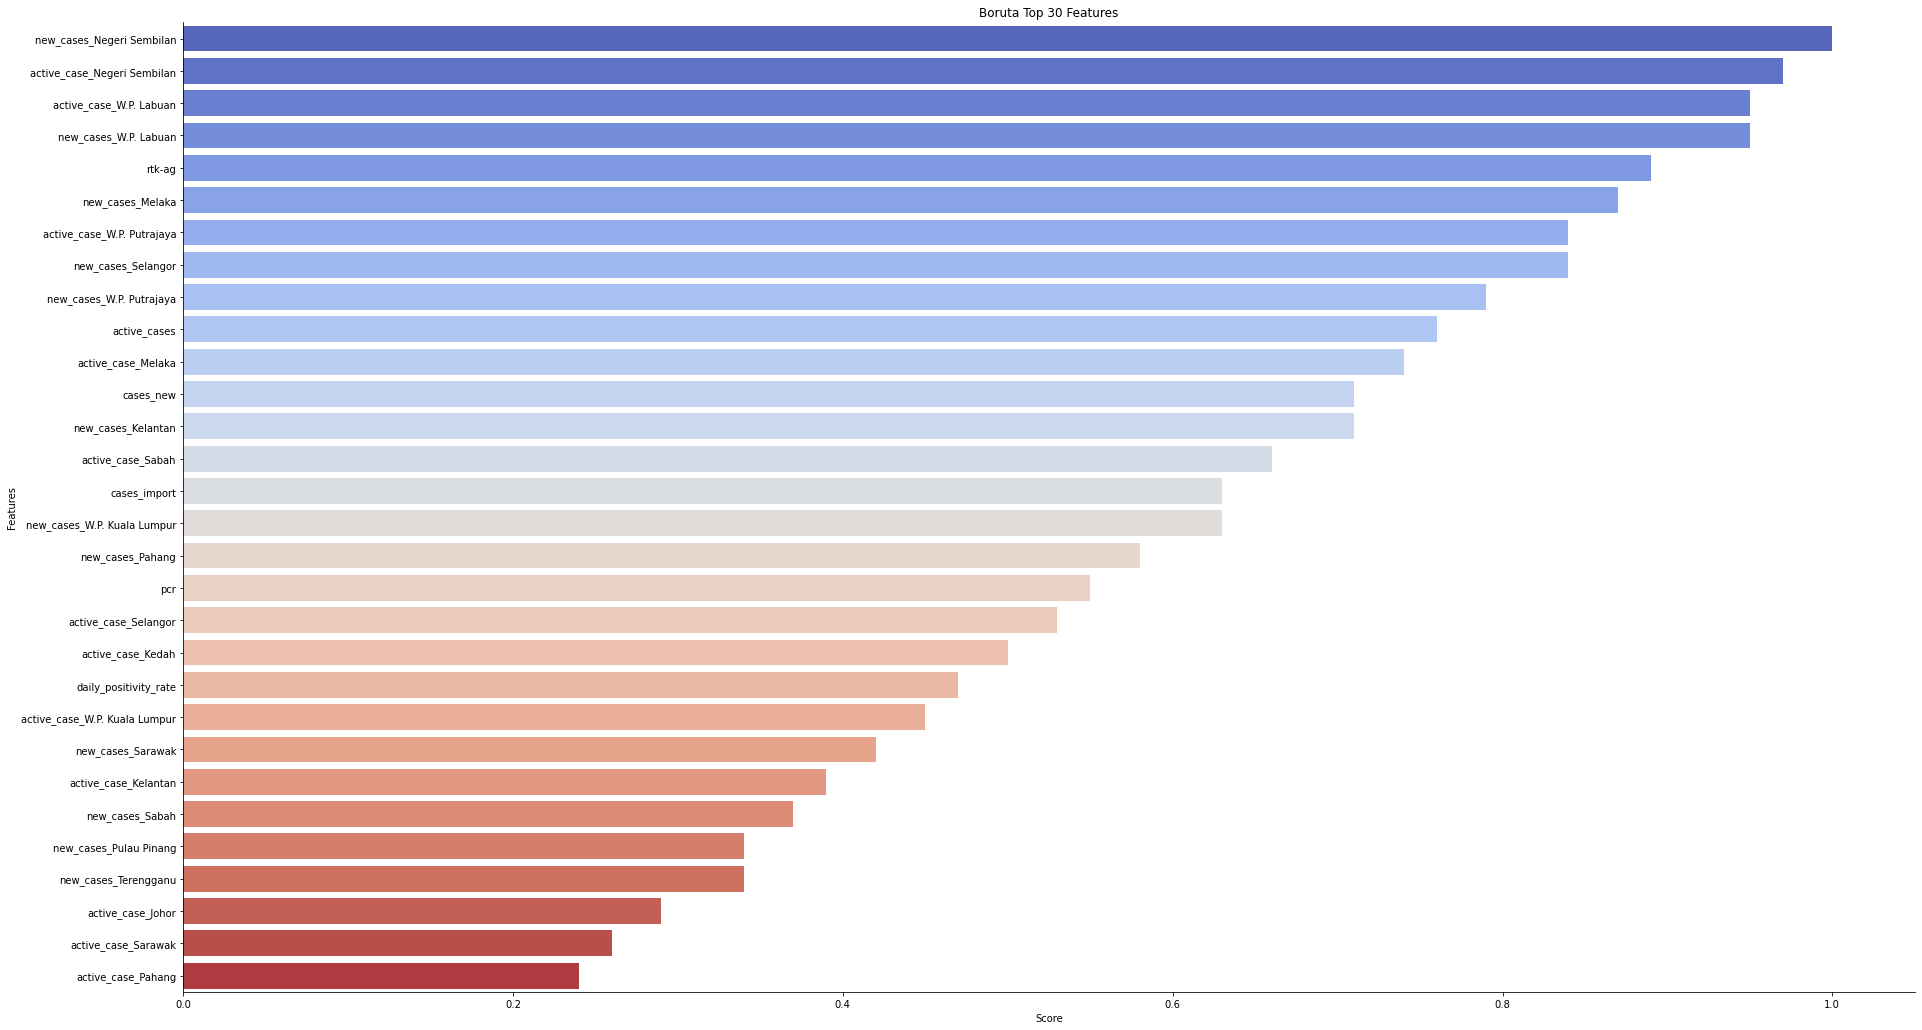

In [56]:
#Boruta 

boruta_selector.fit(X,SelangorY)

# your codes here...
colnames = finalDf.drop(['date','predict_cases','state'], axis =1).columns

boruta_score = ranking(list(map(float,boruta_selector.ranking_)),colnames,order = -1)
boruta_score = pd.DataFrame(list(boruta_score.items()),columns = ['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending = False)

best_feature = boruta_score[boruta_score['Score'] >= 0.5]
display(best_feature)
print (best_feature['Features'].values)

#boruta_score.to_csv("Selangor_Boruta.csv")

sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta Top 30 Features")

,Features,Score
38,active_case_W.P. Putrajaya,1.00
26,active_case_Sabah,1.00
29,new_cases_Selangor,1.00
1,cases_import,1.00
16,active_case_Negeri Sembilan,1.00
15,new_cases_Negeri Sembilan,1.00
14,active_case_Melaka,1.00
13,new_cases_Melaka,1.00
11,new_cases_Kelantan,1.00
30,active_case_Selangor,1.00


['active_case_W.P. Putrajaya' 'active_case_Sabah' 'new_cases_Selangor'
 'cases_import' 'active_case_Negeri Sembilan' 'new_cases_Negeri Sembilan'
 'active_case_Melaka' 'new_cases_Melaka' 'new_cases_Kelantan'
 'active_case_Selangor' 'new_cases_W.P. Labuan' 'active_case_W.P. Labuan'
 'rtk-ag' 'new_cases_Pahang' 'active_cases' 'active_case_Kedah'
 'cases_new' 'pcr' 'new_cases_W.P. Kuala Lumpur'
 'new_cases_W.P. Putrajaya']


Text(0.5, 1.0, 'RFE Top 30 Features')

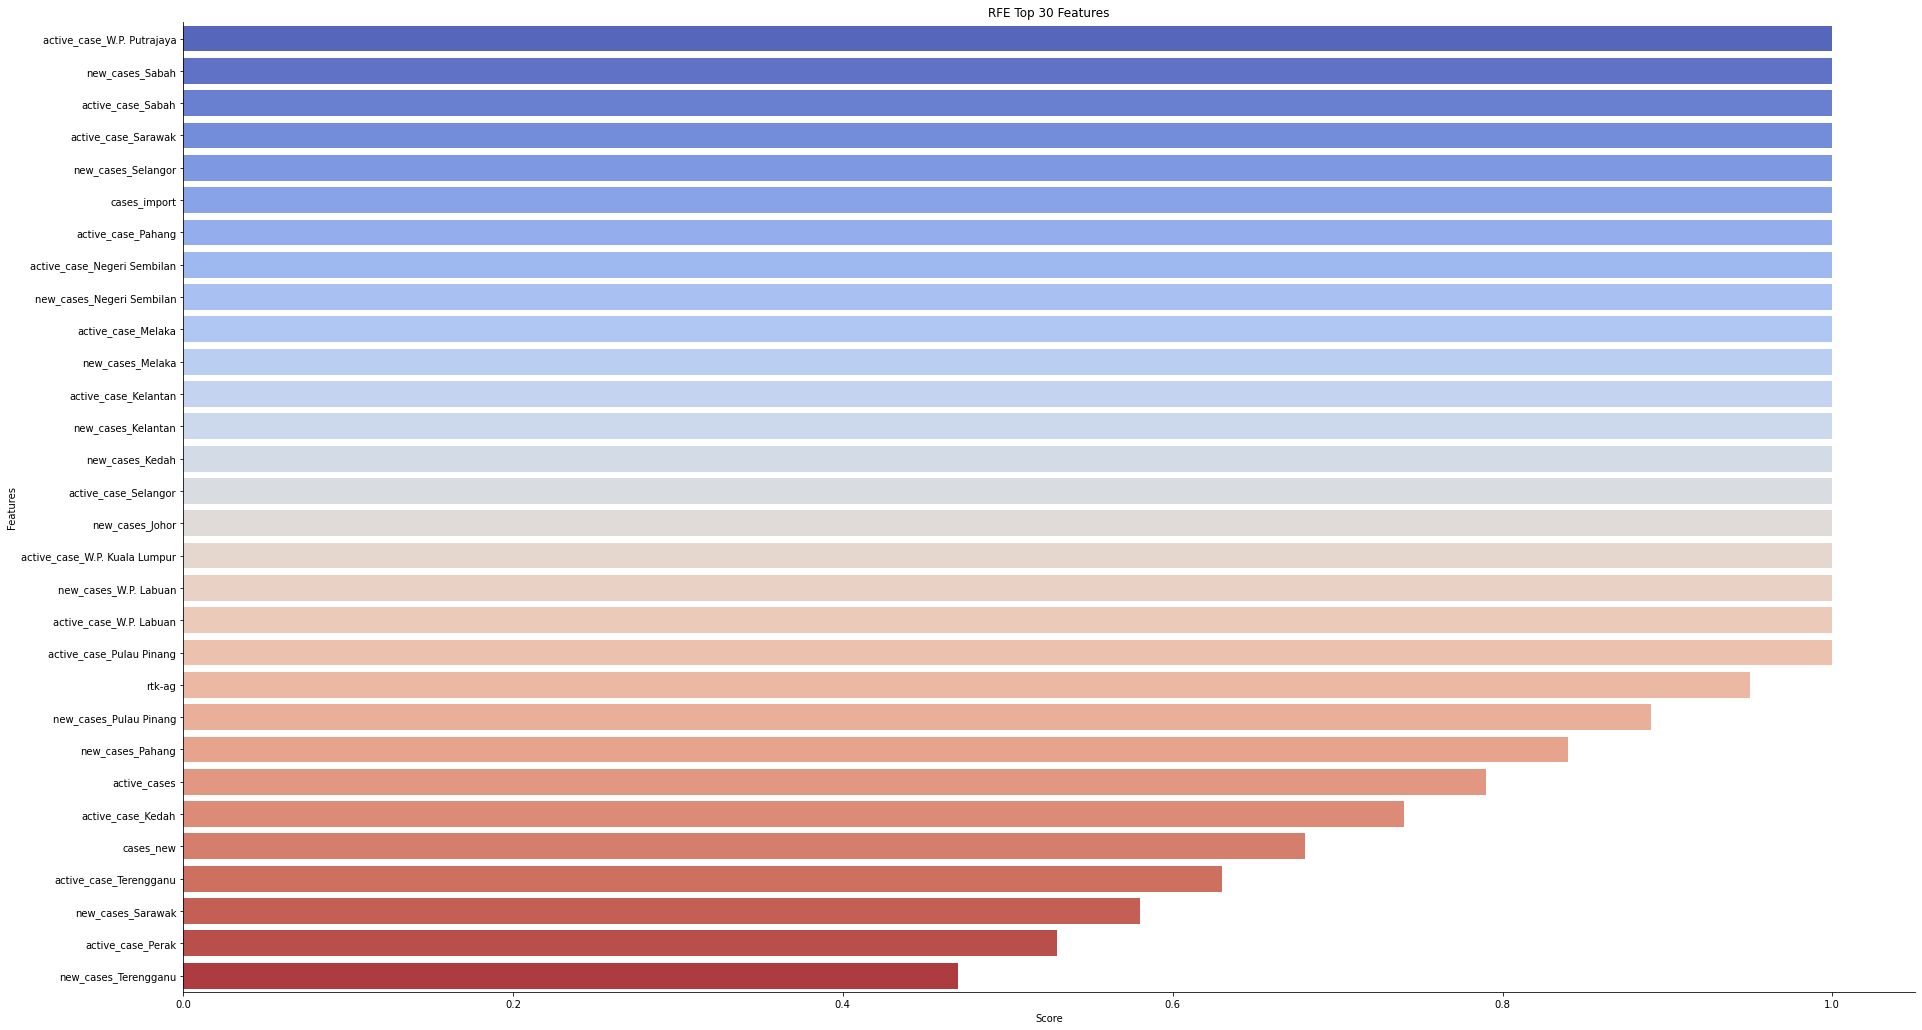

In [60]:
rfe.fit(X,SelangorY)

rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

best_feature = rfe_score[boruta_score['Score'] >= 0.5]
display(best_feature)
print (best_feature['Features'].values)

#rfe_score.to_csv("rfe_Selangor.csv")

sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[0:30], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Top 30 Features")

<h1>Classification</h1>

<h1>Regression</h1>